<a href="https://colab.research.google.com/github/Guljeren/Ml_lab/blob/main/lab_3_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# 1. ЗАГРУЗКА ДАННЫХ (использую твой работающий код)
import os
import json
import pandas as pd
from kaggle.api.kaggle_api_extended import KaggleApi

# Создаем kaggle.json файл автоматически
# ЗАМЕНИТЕ 'your_username' и 'your_api_key' на свои данные!
kaggle_config = {
    "username": "your_username",
    "key": "your_api_key"
}

# Создаем необходимые папки
os.makedirs('/root/.config/kaggle', exist_ok=True)

# Сохраняем конфиг
with open('/root/.config/kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_config, f)

# Устанавливаем правильные права доступа
os.chmod('/root/.config/kaggle/kaggle.json', 0o600)

# Загрузка датасета
api = KaggleApi()
api.authenticate()
dataset = 'uciml/german-credit'
api.dataset_download_files(dataset, path='./data', unzip=True)

csv_files = [file for file in os.listdir('./data') if file.endswith('.csv')]
csv_path = os.path.join('./data', csv_files[0])

df = pd.read_csv(csv_path, low_memory=False)
print(f'Размер датасета: {df.shape}')

# Определение целевого признака
general_keywords = ['risk', 'class', 'default', 'credit']
specific_keywords = ['risk', 'class', 'bad', 'good']
target_column = None

for keyword in general_keywords:
    for col in df.columns:
        if keyword in col.lower() and df[col].count() >= 1000 and df[col].nunique() >= 3:
            target_column = col
            break
    if target_column:
        break

if target_column is None:
    for keyword in specific_keywords:
        for col in df.columns:
            if keyword in col.lower() and df[col].count() >= 1000 and df[col].nunique() >= 3:
                target_column = col
                break
        if target_column:
            break

print(f'Целевой признак: {target_column}')
print(f'Данных: {df[target_column].count()}')
print(f'Уникальных значений: {df[target_column].nunique()}')
print(f'Пример данных:\n{df[target_column].value_counts().head()}')

# Переименовываем целевой признак для удобства
df = df.rename(columns={target_column: 'credit_risk'})

Dataset URL: https://www.kaggle.com/datasets/uciml/german-credit
Размер датасета: (1000, 10)
Целевой признак: Credit amount
Данных: 1000
Уникальных значений: 921
Пример данных:
Credit amount
1275    3
1262    3
1478    3
1393    3
1258    3
Name: count, dtype: int64


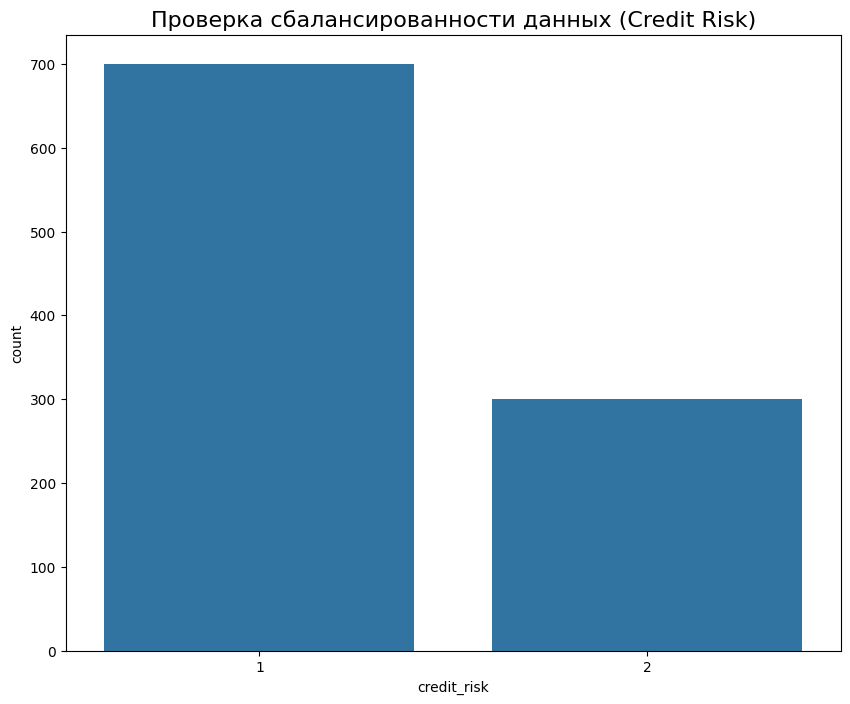

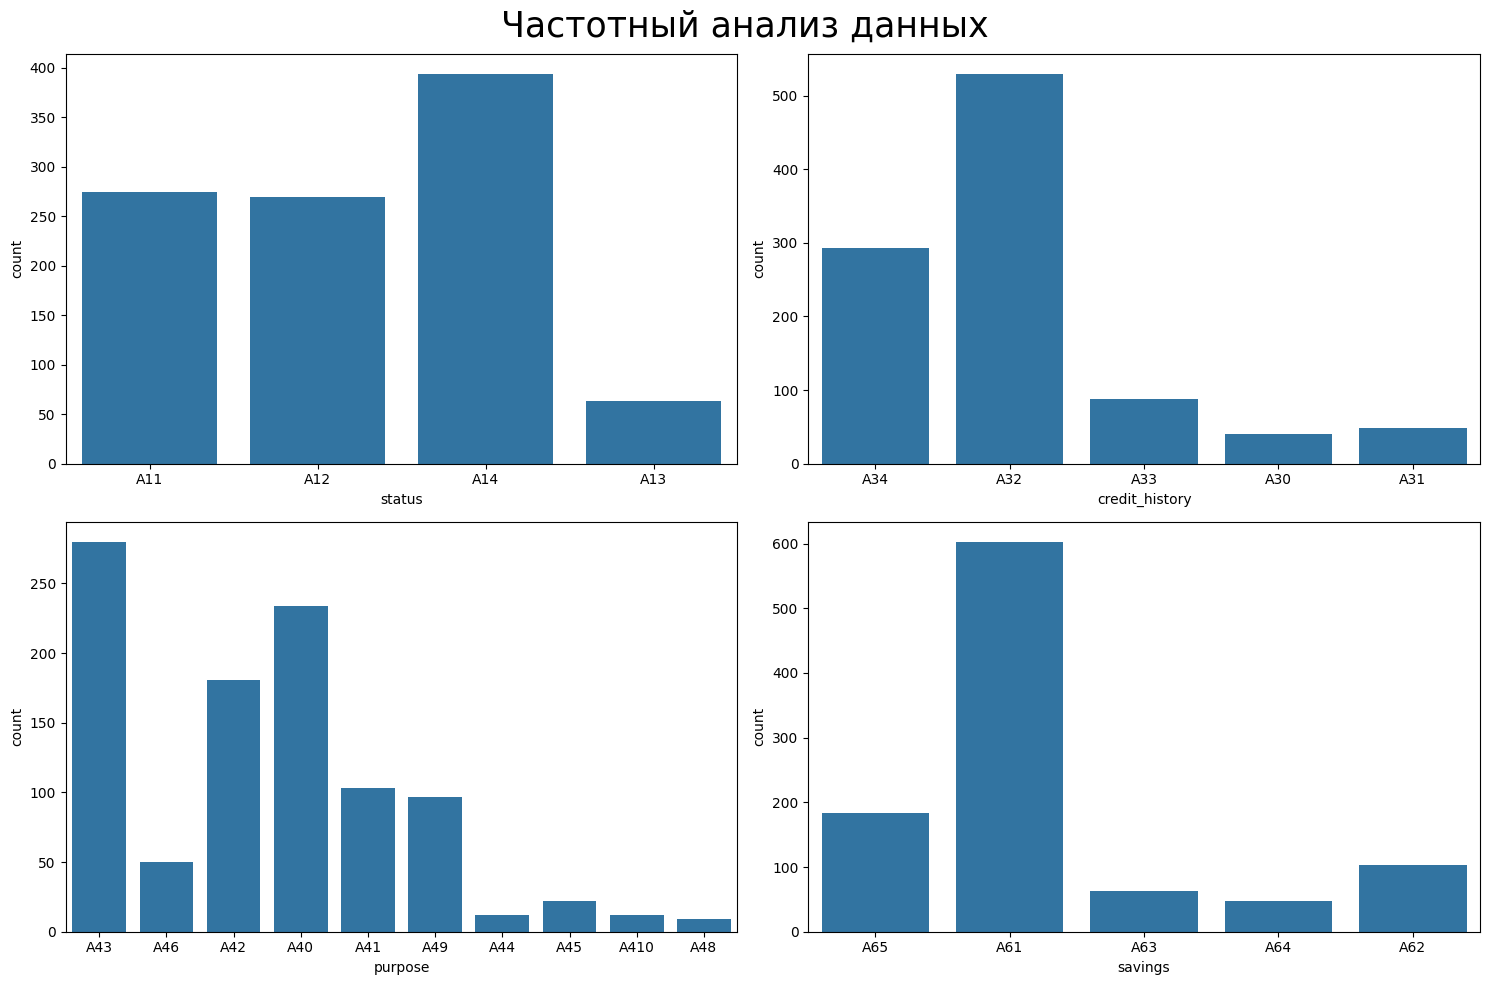

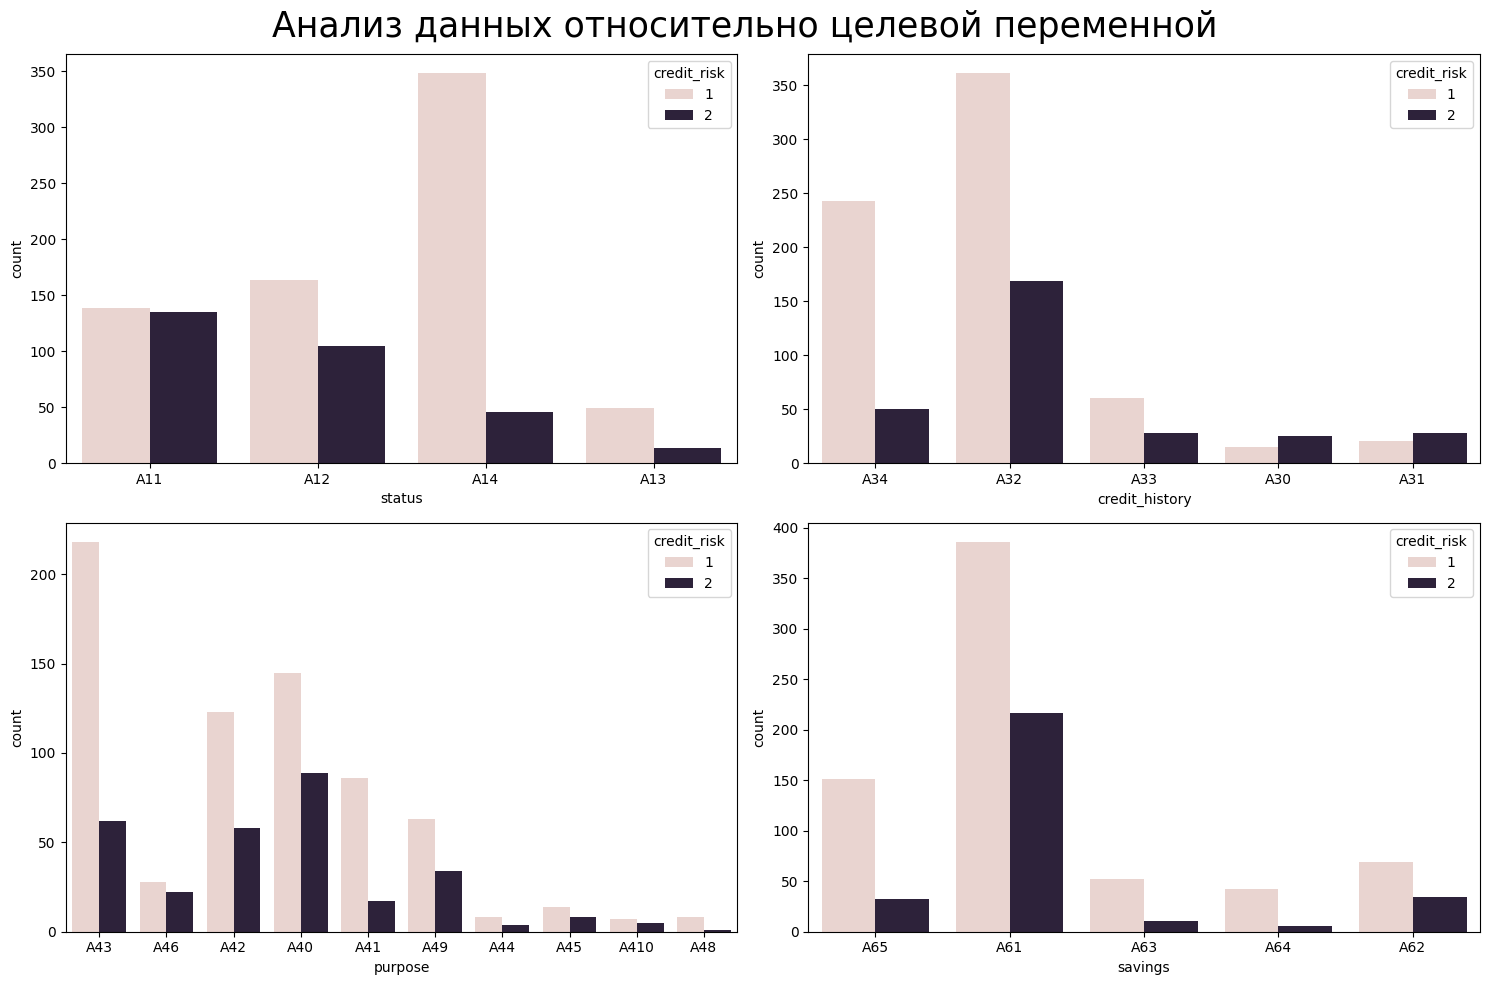

In [11]:
# 2. ВИЗУАЛИЗАЦИИ

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Проверка сбалансированности данных
plt.figure(figsize=(10,8))
plt.title('Проверка сбалансированности данных (Credit Risk)', fontsize=16)
sns.countplot(x='credit_risk', data=df)
plt.show()
#credit_risk = 1 (хороший риск)
#credit_risk = 2 (плохой риск)

# Частотный анализ нескольких параметров
fig, ax = plt.subplots(2, 2, figsize=(15,10))
fig.suptitle('Частотный анализ данных', fontsize=25)

#столбчатые диаграммы
sns.countplot(x="status", data=df, ax=ax[0,0])  #первая строка,первый столбец
sns.countplot(x="credit_history", data=df, ax=ax[0,1]) #кредитная_история
sns.countplot(x="purpose", data=df, ax=ax[1,0]) #цель
sns.countplot(x="savings", data=df, ax=ax[1,1]) #сбережения

# функция для графиков автоматического размещене с правильными расстояниями
plt.tight_layout()
plt.show()

# Анализ относительно целевой переменной
fig, ax = plt.subplots(2, 2, figsize=(15,10))
fig.suptitle('Анализ данных относительно целевой переменной', fontsize=25)

#hue='credit_risk': Разделяет каждый столбец на две части
#Синий цвет - credit_risk = 1 (хороший риск)
#Оранжевый цвет - credit_risk = 2 (плохой риск)
sns.countplot(x="status", hue='credit_risk', data=df, ax=ax[0,0])
sns.countplot(x="credit_history", hue='credit_risk', data=df, ax=ax[0,1])
sns.countplot(x="purpose", hue='credit_risk', data=df, ax=ax[1,0])
sns.countplot(x="savings", hue='credit_risk', data=df, ax=ax[1,1])

plt.tight_layout()
plt.show()

In [4]:
# 3
# Просмотр информации о данных
print("Информация о данных:")
df.info()

print("\nПроверка пропусков:")
print(df.isnull().sum())   #>метод нахождения пропущенных значений

# ДОП: Генерация ошибок для пропусков
# Создаем искусственные пропуски в данных
df_with_errors = df.copy()
import random

# Добавляем случайные пропуски
for col in ['age', 'amount', 'duration']:
    indices = random.sample(range(len(df)), 10)  # 10 случайных индексов
    df_with_errors.loc[indices, col] = np.nan

print("\nПосле добавления искусственных пропусков:")
print(df_with_errors.isnull().sum())

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   status             1000 non-null   object
 1   duration           1000 non-null   int64 
 2   credit_history     1000 non-null   object
 3   purpose            1000 non-null   object
 4   amount             1000 non-null   int64 
 5   savings            1000 non-null   object
 6   employment         1000 non-null   object
 7   installment_rate   1000 non-null   int64 
 8   personal_status    1000 non-null   object
 9   other_debtors      1000 non-null   object
 10  residence          1000 non-null   int64 
 11  property           1000 non-null   object
 12  age                1000 non-null   int64 
 13  other_installment  1000 non-null   object
 14  housing            1000 non-null   object
 15  existing_credits   1000 non-null   int64 
 16  job                100

In [5]:
# 4
# Заполняем пропуски
df_cleaned = df_with_errors.copy()

print("До заполнения пропусков:")
print(df_cleaned.isnull().sum())

# Для числовых столбцов заполняем средним значением
numeric_columns = ['age', 'amount', 'duration']
for col in numeric_columns:
    df_cleaned[col] = df_cleaned[col].fillna(value=df_cleaned[col].mean())

print("После заполнения пропусков:")
print(df_cleaned.isnull().sum())

До заполнения пропусков:
status                0
duration             10
credit_history        0
purpose               0
amount               10
savings               0
employment            0
installment_rate      0
personal_status       0
other_debtors         0
residence             0
property              0
age                  10
other_installment     0
housing               0
existing_credits      0
job                   0
people_liable         0
telephone             0
foreign_worker        0
credit_risk           0
dtype: int64
После заполнения пропусков:
status               0
duration             0
credit_history       0
purpose              0
amount               0
savings              0
employment           0
installment_rate     0
personal_status      0
other_debtors        0
residence            0
property             0
age                  0
other_installment    0
housing              0
existing_credits     0
job                  0
people_liable        0
telephone       

In [6]:
all_data = df_cleaned.copy()

categorical_columns = ['status', 'credit_history', 'purpose', 'savings',
                      'employment', 'personal_status', 'other_debtors',
                      'property', 'other_installment', 'housing',
                      'job', 'telephone', 'foreign_worker']

print("До преобразования в числовые типы:")
print(all_data.head())
print(f"\nТипы данных до преобразования:")
print(all_data.dtypes)

До преобразования в числовые типы:
  status  duration credit_history purpose  amount savings employment  \
0    A11       6.0            A34     A43  1169.0     A65        A75   
1    A12      48.0            A32     A43  5951.0     A61        A73   
2    A14      12.0            A34     A46  2096.0     A61        A74   
3    A11      42.0            A32     A42  7882.0     A61        A74   
4    A11      24.0            A33     A40  4870.0     A61        A73   

   installment_rate personal_status other_debtors  ...  property   age  \
0                 4             A93          A101  ...      A121  67.0   
1                 2             A92          A101  ...      A121  22.0   
2                 2             A93          A101  ...      A121  49.0   
3                 2             A93          A103  ...      A122  45.0   
4                 3             A93          A101  ...      A124  53.0   

   other_installment housing existing_credits   job people_liable  telephone  \
0      

In [7]:
# Создаем копию данных для обработки
all_data = df_cleaned.copy()

# Список категориальных столбцов для преобразования
categorical_columns = ['status', 'credit_history', 'purpose', 'savings',
                      'employment', 'personal_status', 'other_debtors',
                      'property', 'other_installment', 'housing',
                      'job', 'telephone', 'foreign_worker']

# Преобразуем категориальные данные в числовые
for col in categorical_columns:
    unique_vals = all_data[col].unique()
    mapping_dict = {val: idx for idx, val in enumerate(unique_vals)}
    all_data[col] = all_data[col].map(mapping_dict)

print("После преобразования в числовые типы:")
print(all_data.head())
print(f"\nТипы данных после преобразования:")
print(all_data.dtypes)

После преобразования в числовые типы:
   status  duration  credit_history  purpose  amount  savings  employment  \
0       0       6.0               0        0  1169.0        0           0   
1       1      48.0               1        0  5951.0        1           1   
2       2      12.0               0        1  2096.0        1           2   
3       0      42.0               1        2  7882.0        1           2   
4       0      24.0               2        3  4870.0        1           1   

   installment_rate  personal_status  other_debtors  ...  property   age  \
0                 4                0              0  ...         0  67.0   
1                 2                1              0  ...         0  22.0   
2                 2                0              0  ...         0  49.0   
3                 2                0              1  ...         1  45.0   
4                 3                0              0  ...         2  53.0   

   other_installment  housing  existing_cr

In [8]:
# Нормализуние данных
from sklearn.preprocessing import StandardScaler
#импортируем модуля предобработки из sklearn импорт класса для стандартизации данных

# Выделяем числовые признаки для нормализации
numeric_features = ['duration', 'amount', 'installment_rate', 'residence',
                   'age', 'existing_credits', 'people_liable']

print("До нормализации:")
print(all_data[numeric_features].head())

# Применяем StandardScaler
scaler = StandardScaler()
all_data[numeric_features] = scaler.fit_transform(all_data[numeric_features])
#среднее = 0, стандартное отклонение = 1

print("После нормализации:")
print(all_data[numeric_features].head())

До нормализации:
   duration  amount  installment_rate  residence   age  existing_credits  \
0       6.0  1169.0                 4          4  67.0                 2   
1      48.0  5951.0                 2          2  22.0                 1   
2      12.0  2096.0                 2          3  49.0                 1   
3      42.0  7882.0                 2          4  45.0                 1   
4      24.0  4870.0                 3          4  53.0                 2   

   people_liable  
0              1  
1              1  
2              2  
3              2  
4              2  
После нормализации:
   duration    amount  installment_rate  residence       age  \
0 -1.246637 -0.747456          0.918477   1.046987  2.776918   
1  2.247947  0.960675         -0.870183  -0.765977 -1.192144   
2 -0.747411 -0.416331         -0.870183   0.140505  1.189293   
3  1.748721  1.650429         -0.870183   1.046987  0.836488   
4  0.251042  0.574542          0.024147   1.046987  1.542099   

   exis

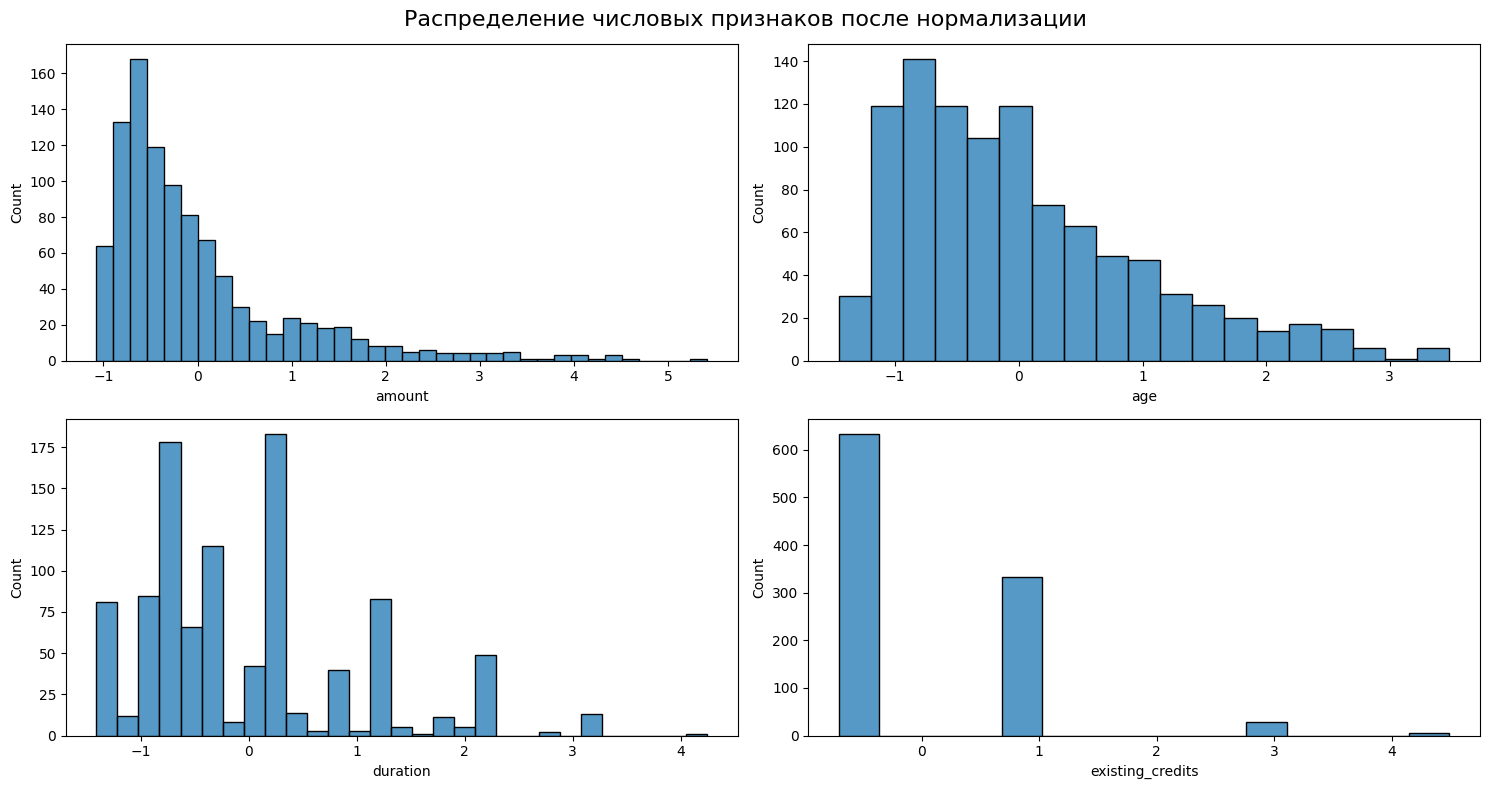

In [9]:
# Проверяем распределение после нормализации
fig, ax = plt.subplots(2, 2, figsize=(15,8))
fig.suptitle('Распределение числовых признаков после нормализации', fontsize=16)

sns.histplot(data=all_data, x='amount', ax=ax[0,0])
sns.histplot(data=all_data, x='age', ax=ax[0,1])
sns.histplot(data=all_data, x='duration', ax=ax[1,0])
sns.histplot(data=all_data, x='existing_credits', ax=ax[1,1])

plt.tight_layout()
plt.show()

In [10]:
# Разделяем на признаки и целевую переменную
X = all_data.drop('credit_risk', axis=1)
y = all_data['credit_risk']

print(f"Размерность признаков: {X.shape}")
print(f"Размерность целевой переменной: {y.shape}")

# Дополнительная проверка готовности данных
print("\nПроверка готовности данных для ML:")
print(f"Есть ли пропуски: {X.isnull().sum().sum() == 0}")
print(f"Все ли данные числовые: {all(dtype in [np.int64, np.float64] for dtype in X.dtypes)}")
print(f"Нормализованы ли числовые признаки: Да")

Размерность признаков: (1000, 20)
Размерность целевой переменной: (1000,)

Проверка готовности данных для ML:
Есть ли пропуски: True
Все ли данные числовые: True
Нормализованы ли числовые признаки: Да
